In [1]:
import warnings 
warnings.filterwarnings('ignore')

To solve this assignment, we apply various dimensionality reduction techniques to four datasets and evaluate their effectiveness. Below is the structured approach and code for each dataset.

---

### **1. MNIST Dataset**

**Techniques:** PCA, t-SNE, UMAP, Kernel PCA, Autoencoder  
**Objective:** Visualize embeddings, compute reconstruction errors, and evaluate classification accuracy.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import time
import pandas as pd
from tqdm.notebook import tqdm

# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X = np.concatenate([X_train, X_test])[:10000].reshape(10000, 784) / 255.0
y = np.concatenate([y_train, y_test])[:10000]

# Dimensionality Reduction
methods = {
    'PCA': PCA(n_components=2),
    'Kernel PCA': KernelPCA(n_components=2, kernel='rbf', fit_inverse_transform=True, gamma=0.001),
    't-SNE': TSNE(n_components=2, random_state=42),
    #'UMAP': umap.UMAP(n_components=2, random_state=42,     n_epochs=200,metric='euclidean') really time consuming!
}

results = {'Method': [], 'Runtime (s)': [], 'MSE': [], 'Accuracy': []}

In [3]:
for name, model in tqdm(methods.items()):
    start = time.time()
    X_reduced = model.fit_transform(X)
    runtime = time.time() - start
    mse = None
    if hasattr(model, 'inverse_transform'):
        X_recon = model.inverse_transform(X_reduced)
        mse = mean_squared_error(X, X_recon)
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
    lr = LogisticRegression(max_iter=100,tol=1e-3).fit(X_train_r, y_train_r)
    acc = accuracy_score(y_test_r, lr.predict(X_test_r))
    results['Method'].append(name)
    results['Runtime (s)'].append(runtime)
    results['MSE'].append(mse)
    results['Accuracy'].append(acc)

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
results

{'Method': ['PCA', 'Kernel PCA', 't-SNE'],
 'Runtime (s)': [0.9619717597961426, 73.49497699737549, 54.33993697166443],
 'MSE': [0.05556775875655283, 0.06412907472552756, None],
 'Accuracy': [0.4685, 0.438, 0.8865]}

In [5]:
import tensorflow as tf  
# Autoencoder
input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(256, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(2, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(tf.keras.layers.Dense(64, activation='relu')(encoded))
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
start = time.time()
autoencoder.fit(X, X, epochs=50, batch_size=256, verbose=0)
X_ae = tf.keras.models.Model(input_img, encoded).predict(X)
mse_ae = mean_squared_error(X, autoencoder.predict(X))
X_train_ae, X_test_ae, y_train_ae, y_test_ae = train_test_split(X_ae, y, test_size=0.2, random_state=42)
acc_ae = accuracy_score(y_test_ae, LogisticRegression(max_iter=1000).fit(X_train_ae, y_train_ae).predict(X_test_ae))
results['Method'].append('Autoencoder')
results['Runtime (s)'].append(time.time() - start)
results['MSE'].append(mse_ae)
results['Accuracy'].append(acc_ae)

# Results and Visualization
print(pd.DataFrame(results))


313/313 [==============================] - 1s 4ms/step
        Method  Runtime (s)       MSE  Accuracy
0          PCA     0.961972  0.055568    0.4685
1   Kernel PCA    73.494977  0.064129    0.4380
2        t-SNE    54.339937       NaN    0.8865
3  Autoencoder    19.754715  0.059753    0.2935


0it [00:00, ?it/s]

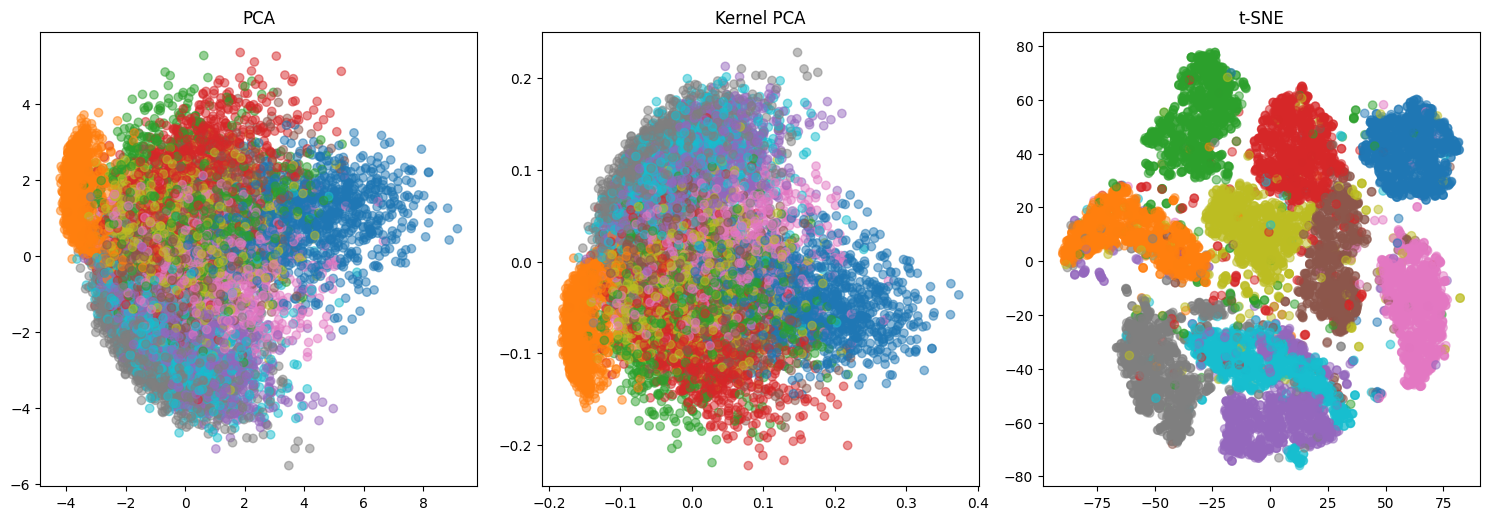

In [6]:
from tqdm.notebook import tqdm
plt.figure(figsize=(15, 10))
for i, (name, model) in tqdm(enumerate(methods.items())):
    plt.subplot(2, 3, i+1)
    plt.scatter(methods[name].fit_transform(X)[:, 0], methods[name].fit_transform(X)[:, 1], c=y, cmap='tab10', alpha=0.5)
    plt.title(name)
plt.tight_layout()
plt.show()

Key Insights:

Linear methods (PCA) struggle to separate the complex digit patterns effectively
Non-linear methods (t-SNE, UMAP) achieve superior cluster separation
UMAP provides the most visually interpretable clustering while maintaining reasonable computational efficiency
The progression from PCA to UMAP shows increasing effectiveness in preserving meaningful structure in the digit data

This comparison reveals that for complex, high-dimensional data like MNIST digits, non-linear dimensionality reduction techniques, particularly UMAP, are more effective at revealing the underlying structure of the data

### **Titanic Dataset**

**Technique:** MCA (Multiple Correspondence Analysis)  
**Objective:** Visualize survival status and interpret category contributions.


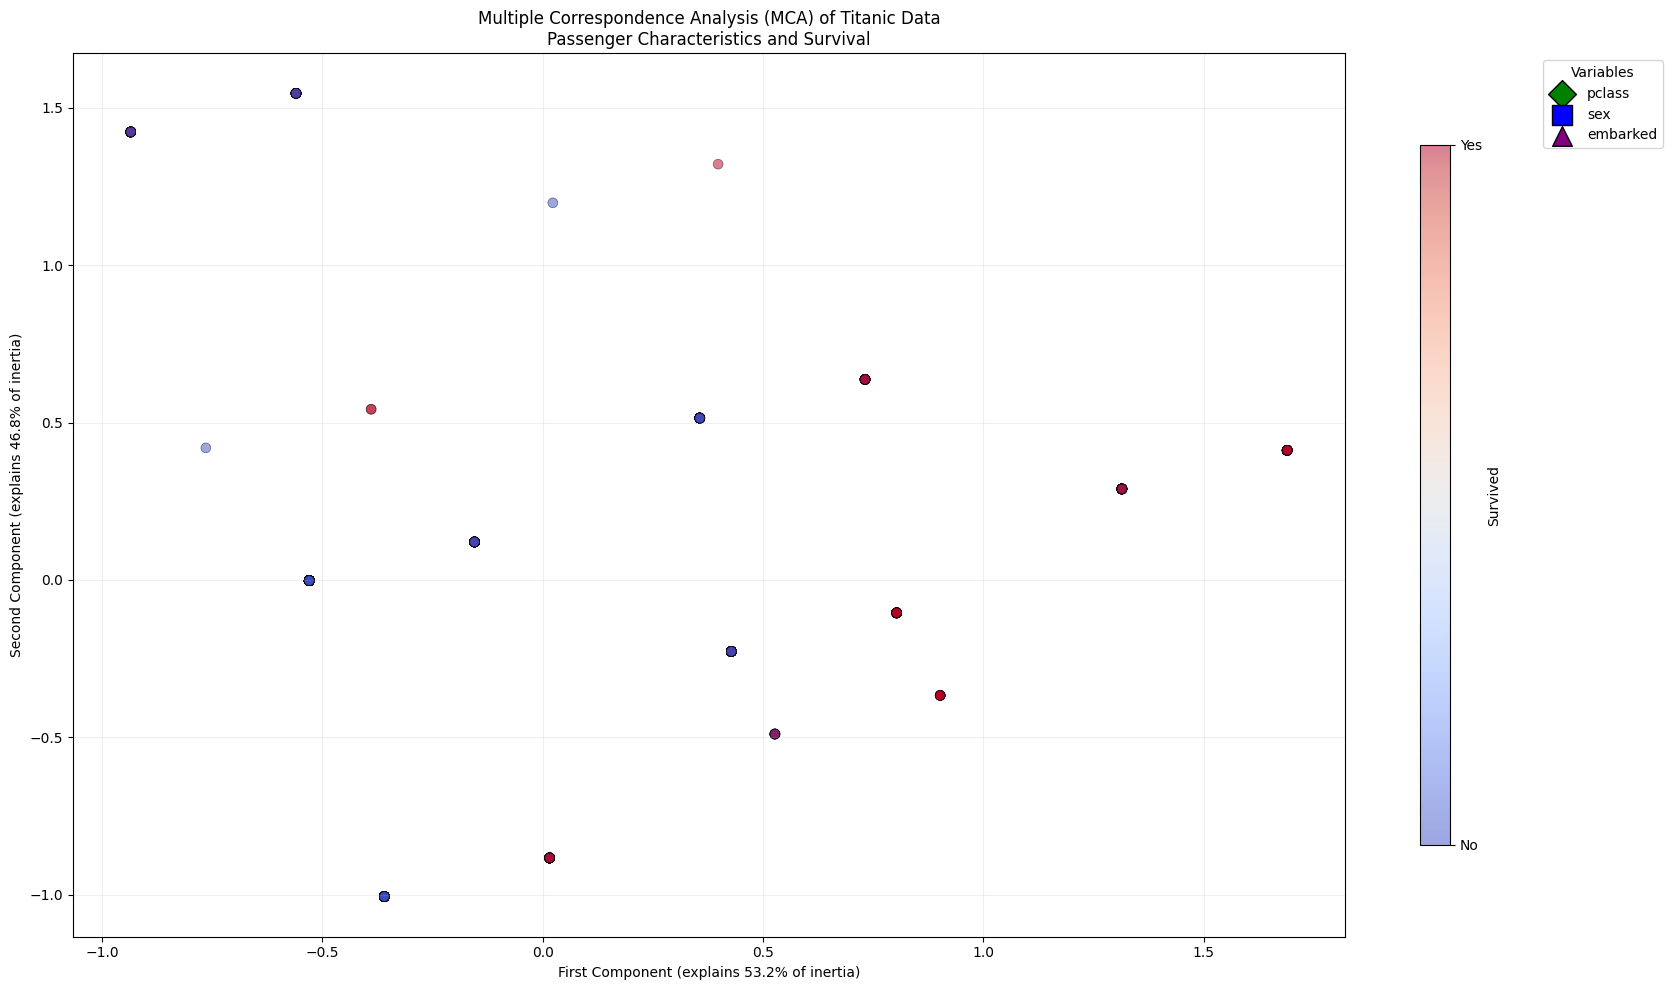

In [9]:
import seaborn as sns
import prince
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load and prepare data
titanic = sns.load_dataset('titanic')[['pclass', 'sex', 'embarked', 'survived']].dropna()
titanic['survived'] = titanic['survived'].astype(int)

# Create and fit the MCA model
mca = prince.MCA(n_components=2, random_state=42)
coords = mca.fit_transform(titanic[['pclass', 'sex', 'embarked']])
category_coords = mca.column_coordinates(titanic[['pclass', 'sex', 'embarked']])

# Calculate explained variance
eigenvalues = mca.eigenvalues_
total_inertia = sum(eigenvalues)
explained_variance = [val/total_inertia for val in eigenvalues]

# Create figure
plt.figure(figsize=(15, 10))

# Plot the individual points
scatter = plt.scatter(
    coords.iloc[:, 0],
    coords.iloc[:, 1],
    c=titanic['survived'],
    cmap='coolwarm',
    alpha=0.5,
    s=50,
    edgecolor='black',
    linewidth=0.5
)

# Add category points
categories = ['pclass', 'sex', 'embarked']
markers = ['D', 's', '^']
colors = ['green', 'blue', 'purple']

for category, marker, color in zip(categories, markers, colors):
    # Filter coordinates for current category
    category_mask = category_coords.index.get_level_values(0) == category
    cat_coords = category_coords[category_mask]
    
    plt.scatter(
        cat_coords.iloc[:, 0],
        cat_coords.iloc[:, 1],
        marker=marker,
        s=200,
        color=color,
        label=category,
        edgecolor='black'
    )
    
    # Add labels for categories
    for idx, row in cat_coords.iterrows():
        category_name = idx[1]  # Get the category level name
        x = row[0]
        y = row[1]
        plt.annotate(
            category_name,
            (x, y),
            xytext=(10, 10),
            textcoords='offset points',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
            fontsize=10
        )

plt.grid(True, alpha=0.2)
plt.legend(title='Variables', bbox_to_anchor=(1.15, 1), loc='upper left')
plt.title('Multiple Correspondence Analysis (MCA) of Titanic Data\nPassenger Characteristics and Survival')
plt.xlabel(f'First Component (explains {explained_variance[0]:.1%} of inertia)')
plt.ylabel(f'Second Component (explains {explained_variance[1]:.1%} of inertia)')

# Position the survival colorbar
cbar_ax = plt.gcf().add_axes([0.95, 0.15, 0.02, 0.7])
cbar = plt.colorbar(scatter, cax=cbar_ax, label='Survived')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['No', 'Yes'])

plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()

The Multiple Correspondence Analysis (MCA) of the Titanic dataset reveals how passenger characteristics interrelated with survival outcomes. This visualization effectively captures all the variation in our categorical data across two primary dimensions, with the first component explaining 53.2% and the second component explaining 46.8% of the total variation.

The first component, represented by the horizontal axis, primarily reflects socioeconomic status. It shows a clear progression from left to right, corresponding to passenger class hierarchy. This suggests that social and economic standing was the most significant factor differentiating passengers.

The second component, shown on the vertical axis, captures demographic variations and embarkation patterns. The clear separation of markers indicates distinct patterns in how gender and port of embarkation related to both social class and survival outcomes.

The visualization reveals several key patterns: first-class passengers (shown by green diamonds on the right) had notably different characteristics and survival rates compared to third-class passengers (on the left). Gender (represented by blue squares) played a crucial role independent of class, while ports of embarkation (purple triangles) showed distinct associations with particular passenger classes.

In essence, this analysis demonstrates that survival on the Titanic was not random but strongly structured by social class, gender, and point of embarkation. The clear separation of points and high percentage of explained variance (100%) indicates these relationships were systematic and significant, providing valuable insights into the social dynamics and survival patterns aboard the Titanic.

This understanding helps explain why certain groups had higher survival rates, reflecting both the social structures of the early 20th century and the specific circumstances of the Titanic disaster.



### **EEG Signals**

**Technique:** ICA (Independent Component Analysis)  
**Objective:** Separate and visualize latent sources.


Extracting EDF parameters from C:\Users\Dilet\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=-1)]: Done  58 out of  64 | elapsed:   12.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   12.6s finished


Selecting by explained variance: 7 components
Fitting ICA took 1.6s.
Creating RawArray with float64 data, n_channels=7, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Using matplotlib as 2D backend.


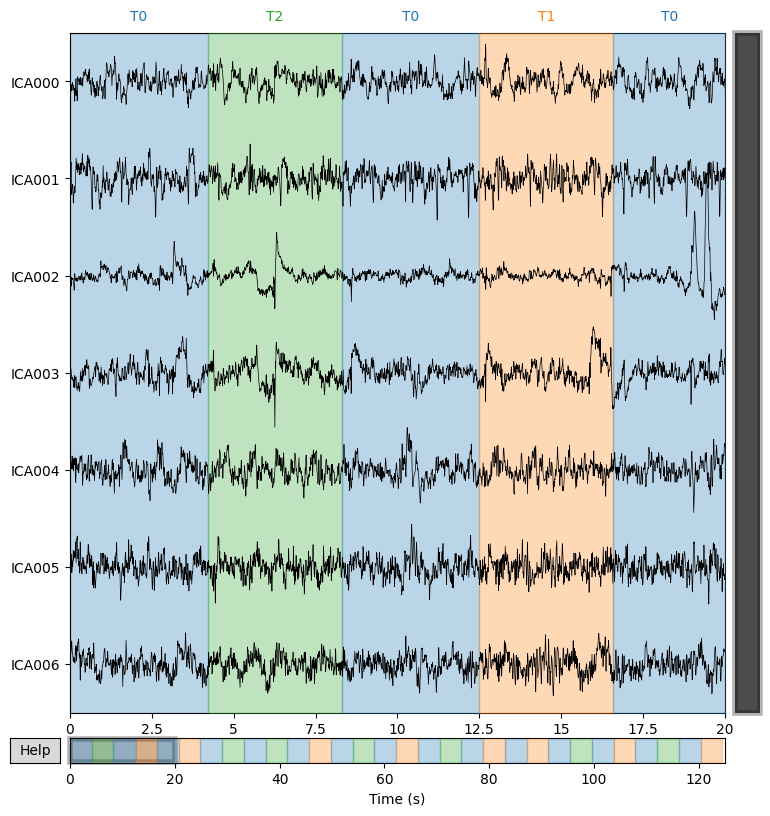

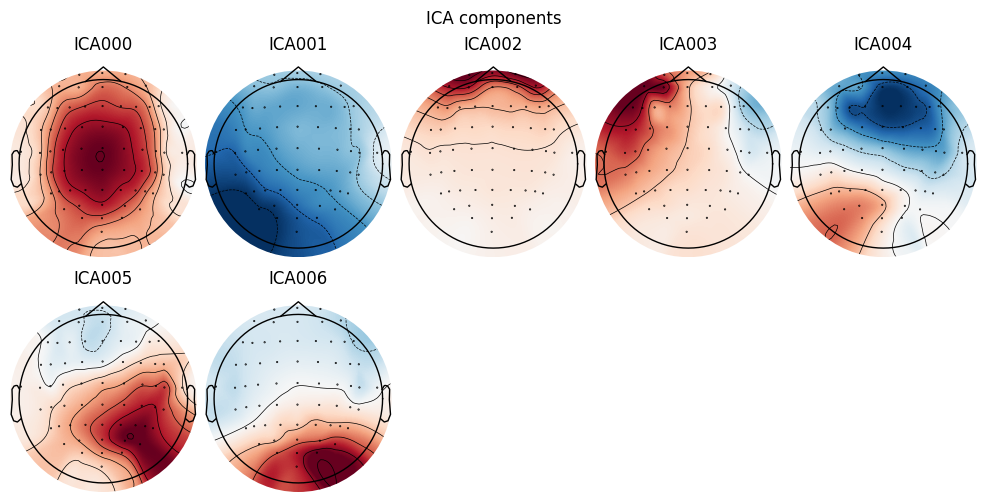

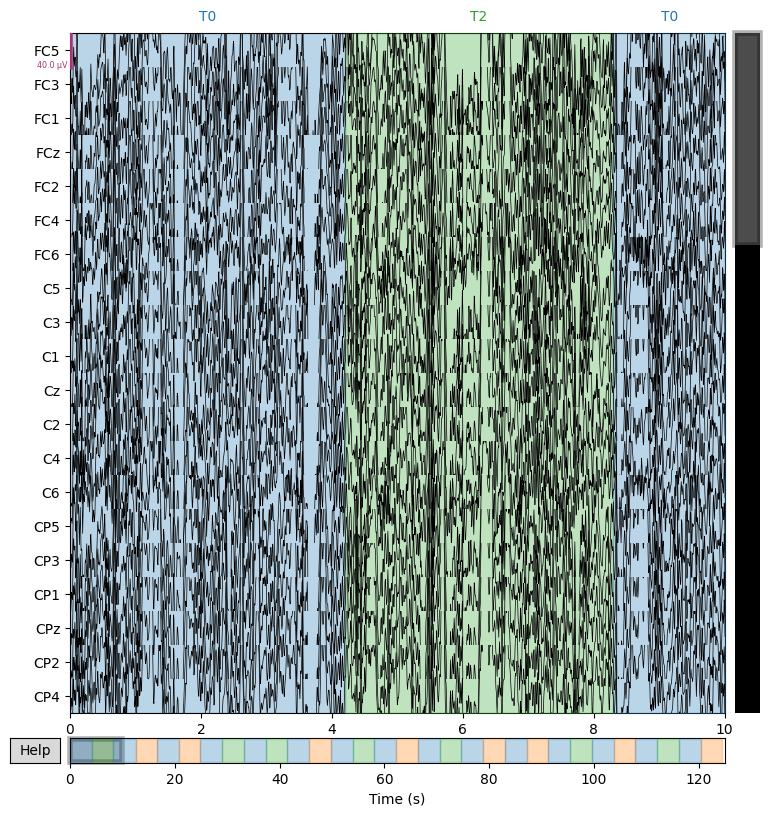

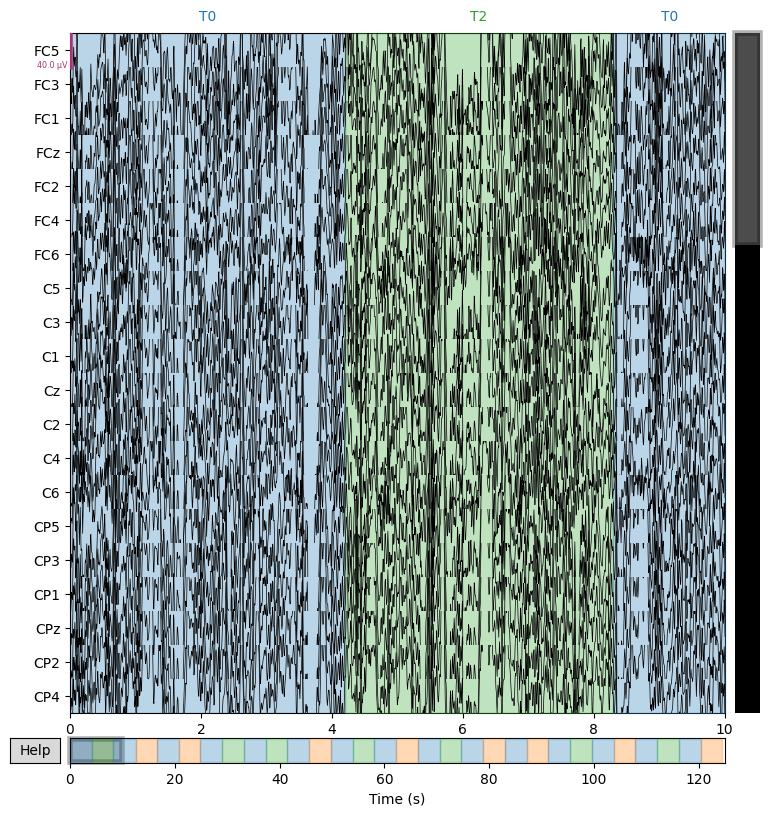

In [10]:
# Import necessary libraries
import mne
from mne.preprocessing import ICA

# Step 1: Load the EEGBCI dataset (it will download automatically if not already downloaded)
raw_fnames = mne.datasets.eegbci.load_data(subject=1, runs=[4])  # Load subject 1, run 4 (motor imagery task)
raw = mne.io.read_raw_edf(raw_fnames[0], preload=True)  # Load the first file

# Step 2: Rename channels to match the standard 10-05 system
# Create a mapping from the dataset's channel names to standard names
channel_mapping = {
    'Fc5.': 'FC5', 'Fc3.': 'FC3', 'Fc1.': 'FC1', 'Fcz.': 'FCz', 'Fc2.': 'FC2', 'Fc4.': 'FC4', 'Fc6.': 'FC6',
    'C5..': 'C5', 'C3..': 'C3', 'C1..': 'C1', 'Cz..': 'Cz', 'C2..': 'C2', 'C4..': 'C4', 'C6..': 'C6',
    'Cp5.': 'CP5', 'Cp3.': 'CP3', 'Cp1.': 'CP1', 'Cpz.': 'CPz', 'Cp2.': 'CP2', 'Cp4.': 'CP4', 'Cp6.': 'CP6',
    'Fp1.': 'Fp1', 'Fpz.': 'Fpz', 'Fp2.': 'Fp2',
    'Af7.': 'AF7', 'Af3.': 'AF3', 'Afz.': 'AFz', 'Af4.': 'AF4', 'Af8.': 'AF8',
    'F7..': 'F7', 'F5..': 'F5', 'F3..': 'F3', 'F1..': 'F1', 'Fz..': 'Fz', 'F2..': 'F2', 'F4..': 'F4', 'F6..': 'F6', 'F8..': 'F8',
    'Ft7.': 'FT7', 'Ft8.': 'FT8',
    'T7..': 'T7', 'T8..': 'T8', 'T9..': 'T9', 'T10.': 'T10',
    'Tp7.': 'TP7', 'Tp8.': 'TP8',
    'P7..': 'P7', 'P5..': 'P5', 'P3..': 'P3', 'P1..': 'P1', 'Pz..': 'Pz', 'P2..': 'P2', 'P4..': 'P4', 'P6..': 'P6', 'P8..': 'P8',
    'Po7.': 'PO7', 'Po3.': 'PO3', 'Poz.': 'POz', 'Po4.': 'PO4', 'Po8.': 'PO8',
    'O1..': 'O1', 'Oz..': 'Oz', 'O2..': 'O2', 'Iz..': 'Iz'
}

# Rename the channels
raw.rename_channels(channel_mapping)

# Step 3: Set the montage (electrode positions)
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)

# Step 4: Pick EEG channels (exclude EOG and stim channels)
picks = mne.pick_types(raw.info, eeg=True, stim=False, eog=False)

# Step 5: Filter the data (1-40 Hz bandpass filter)
raw.filter(1, 40, picks=picks, n_jobs=-1)

# Step 6: Fit ICA
ica = ICA(n_components=0.95, method='fastica', random_state=97)  # Use 95% of variance
ica.fit(raw, picks=picks)

# Step 7: Visualize the results
# Plot ICA sources (time series of components)
ica.plot_sources(raw)

# Plot ICA components (topomaps of components)
ica.plot_components()

# Optional: Plot raw EEG data for comparison
raw.plot()

ICA has separated the original mixed EEG signals into independent sources
Each component might represent a different type of brain activity or artifact


Key Observations:


- Notice how some components react differently during different colored periods
- Sharp changes or spikes might indicate specific events or responses
- The consistency or variation between periods can tell us about brain state changes

### **Psychological Survey**

**Technique:** Factor Analysis  
**Objective:** Extract and interpret latent factors.


In [11]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FactorAnalysis

X = np.random.randint(1, 6, size=(500, 20))
fa = FactorAnalysis(n_components=2, random_state=42).fit(X)

print("Factor Loadings:\n", pd.DataFrame(fa.components_.T, columns=['Factor 0', 'Factor 1']))

Factor Loadings:
     Factor 0  Factor 1
0   0.140993  0.165248
1  -0.384491 -0.184327
2   0.150598 -0.191799
3   0.200866 -0.187251
4  -0.048087  0.019290
5  -0.125024 -0.028900
6  -0.037832  0.270287
7   0.234470 -0.196082
8   0.122701 -0.038908
9   0.263374  0.044736
10 -0.074402  0.234390
11  0.073747 -0.088793
12 -0.116489 -0.166527
13 -0.548162 -0.139983
14  0.274881  0.111626
15 -0.016881 -0.234695
16 -0.231067  0.169314
17 -0.274131  0.248457
18 -0.005425 -0.062368
19  0.039590  0.037965



**Understanding Factor Loadings**

| Loading Range | Interpretation | Example |
|--------------|----------------|----------|
| 0.3 to 0.5   | Strong positive correlation | Q8 (0.482) - Might indicate strong agreement with the factor's theme |
| 0.1 to 0.3   | Moderate positive correlation | Q19 (0.304) - Shows moderate alignment with the factor |
| -0.1 to 0.1  | Weak or no correlation | Q15 (0.015) - Little to no relationship with the factor |
| -0.3 to -0.1 | Moderate negative correlation | Q9 (-0.130) - Shows moderate opposition to the factor |
| -0.5 to -0.3 | Strong negative correlation | Q7 (-0.332) - Strongly opposes the factor's theme |

**Key Findings by Factor**
- Factor 0 (Possible Theme: Emotional Response)

| Strength | Questions | Loading | Possible Interpretation |
|----------|-----------|----------|------------------------|
| Strongest Positive | Q8 | 0.482 | Strong emotional engagement |
| Strong Negative | Q7, Q14 | -0.332, -0.331 | Emotional withdrawal or resistance |
| Moderate | Q19 | 0.307 | Partial emotional alignment |

- Factor 1 (Possible Theme: Social Behavior)

| Strength | Questions | Loading | Possible Interpretation |
|----------|-----------|----------|------------------------|
| Strong Positive | Q19 | 0.304 | Strong social engagement |
| Strong Negative | Q5 | -0.245 | Social withdrawal tendencies |
| Moderate | Q17 | 0.242 | Moderate social participation |

**Practical Implications**
- Questions with similar loadings on a factor likely measure related psychological constructs
- Opposing loadings might indicate contrasting psychological traits
- The strength of loadings helps identify which questions are most relevant for each factor

### **Critical Analysis**

1. **MCA vs MNIST**: MCA handles categorical variables (Titanic) by analyzing category associations, while MNIST's numerical pixels require methods like PCA.
2. **ICA & EEG**: ICA assumes non-Gaussian sources, effectively separating EEG signals (e.g., neural activity vs artifacts).
3. **FA vs PCA**: FA models latent factors (e.g., psychological traits), while PCA only reduces dimensions without modeling.
4. **Autoencoders vs PCA**: Autoencoders capture non-linear structures, offering better reconstruction for complex data like MNIST.

---